# Projet : Consommation et production électrique en France: Exploration du dataset Régional

_________________________________________
### 0.Organisation
_________________________________________

#### 0.1. Extract and transform data

In [2]:
#Imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### 0.2. Useful functions

In [3]:
# Creating function to extract and concatenate csv files

def create_datetime_indexes( df ):
    datetime_index = pd.DatetimeIndex(df['Date'] + ' ' + df['Heures'])
    df.index = datetime_index
    df = df.drop(columns=['Date', 'Heures'])
    return df

def extract_clean( files, cols ) :

    # Ceci est un générateur. Les données ne sont pas calculées immédiatement.
    # Mais il me garatit que l'information sera disponible au moment où j'en ai besoin. 
    # https://book.pythontips.com/en/latest/generators.html
    # En compréhension de générateur : 
    # https://python-reference.readthedocs.io/en/latest/docs/comprehensions/gen_expression.html

    gen = ( pd.read_csv(
            filepath_or_buffer=f, 
            sep='\t', 
            encoding='ISO-8859-1', 
            na_values=['ND', '-', 'NA'],
            index_col=False) 
       for f in files 
    )
    
    # Ici j'ai mis un exemple d'utilisation de 'pipe' pour brancher une fonction au milieu du chaînage.
    # Pipe : https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pipe.html
    return (
        pd.concat( gen )
        .dropna(
            subset=['Consommation', 'Date', 'Heures'],
            how='any')
        .loc[:, cols]
        .pipe(create_datetime_indexes)
    )


#### 0.3. Preparing to load


In [4]:
# Prepare the list of files to load
data_folder = '../data_rte/'
files = os.listdir(data_folder)
regional_files = [ data_folder + f for f in files if 'eCO2mix_RTE_Annuel' not in f ]

cols = [ 'Périmètre', 'Date', 'Heures', 'Consommation', 'Thermique',
       'Nucléaire', 'Eolien', 'Solaire', 'Hydraulique', 'Pompage',
       'Bioénergies', 'Ech. physiques'
]

df_regional = extract_clean( regional_files, cols )

df_regional.to_pickle('./data_rte_regional.pkl')

#df_regional.info()

/tmp/ipykernel_12953/2263363627.py:17: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  gen = ( pd.read_csv(


#### 0.4. Preliminary Analysis

In [5]:
# Converting to pickle
df_regional = pd.read_pickle('./data_rte_regional.pkl')
#df_regional.info()

In [6]:
# Set of Regions
df_regional['Périmètre'].unique()

array(['Ile-de-France', 'Bretagne', 'Hauts-de-France', 'Normandie',
       'Bourgogne-Franche-Comté', 'PACA', 'Centre-Val de Loire',
       'Occitanie', 'Pays-de-la-Loire', 'Auvergne-Rhône-Alpes',
       'Nouvelle-Aquitaine', 'Grand-Est'], dtype=object)

In [7]:
# Do I have the number of values for each region ?
df_regional['Périmètre'].value_counts()

Périmètre
Ile-de-France              105167
Bretagne                   105167
Hauts-de-France            105167
Normandie                  105167
Bourgogne-Franche-Comté    105167
PACA                       105167
Centre-Val de Loire        105167
Occitanie                  105167
Pays-de-la-Loire           105167
Auvergne-Rhône-Alpes       105167
Nouvelle-Aquitaine         105167
Grand-Est                  105167
Name: count, dtype: int64

____________________________________________________
### 1.Analyse générale
____________________________________________________

##### 1.0. Organizing and Cleaning Regional Consumption Dataframe

In [8]:
# Defining a new variable (regional_consomption)
regional_consomption = df_regional

In [9]:
#Cleaning Regional Consumption dataset
regional_consomption = (regional_consomption.drop(columns=['Thermique', 'Nucléaire', 'Eolien', 
                                                            'Solaire', 'Hydraulique', 
                                                            'Pompage', 'Bioénergies', 'Ech. physiques'])
                                            .reset_index()
                                            .rename(columns={'Périmètre': 'Regions',
                                                            'Consommation': 'Consomption(Gwh)',
                                                            'index': 'Datetime'})
                                            
)

In [10]:
regional_consomption['Datetime'] = pd.to_datetime(regional_consomption['Datetime'])
regional_consomption = (regional_consomption.groupby(['Regions', 
                                         pd.Grouper(key='Datetime', freq='Y')])['Consomption(Gwh)']
                                         .sum()
                                         .loc[:, '2018']
                                         .astype(int)
                        )


In [11]:
regional_consomption = pd.DataFrame(regional_consomption)

In [12]:
regional_consomption = (regional_consomption.reset_index())

regional_consomption

,Regions,Consomption(Gwh)
0,Auvergne-Rhône-Alpes,134068058
1,Bourgogne-Franche-Comté,42829648
2,Bretagne,45053105
3,Centre-Val de Loire,37557332
4,Grand-Est,91868917
5,Hauts-de-France,101815048
6,Ile-de-France,141593960
7,Normandie,56079329
8,Nouvelle-Aquitaine,87595610
9,Occitanie,76903481


#### 1.1. Tracer sur un même graphique la consommation des différentes régions en fonction du temps
_____________________________________________

<AxesSubplot:>

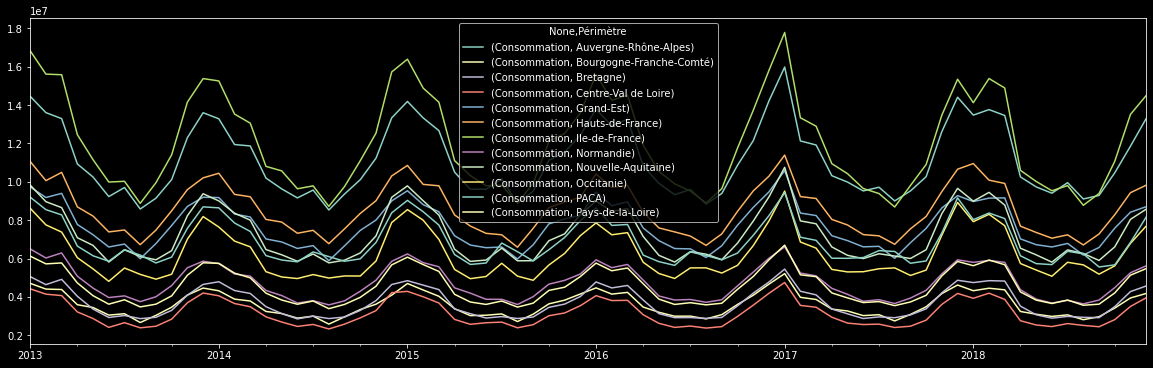

In [13]:
# Plotting Energy Consumption per Region

regional_consomption_plot = (df_regional.drop(columns=['Thermique', 'Nucléaire', 'Eolien', 'Solaire', 'Hydraulique', 
                                    'Pompage', 'Bioénergies', 'Ech. physiques'])
                                            .groupby(['Périmètre', pd.Grouper(freq="M")])
                                            .sum()
                                            .unstack(level=0)
                                            
                                             )


regional_consomption_plot.plot(figsize=(20, 6))
                                

#### 1.2. Peut-on observer des différences comportementales significatives entre les régions ? (par ex entre une région du nord et une région du sud)
_________________________________________________

In [14]:
#

#### 1.3. Quelles régions sont les plus consommatrices ?
____________________________________________

In [15]:
# Sort values 
regional_consomption.sort_values(by='Consomption(Gwh)', ascending=False)

,Regions,Consomption(Gwh)
6,Ile-de-France,141593960
0,Auvergne-Rhône-Alpes,134068058
5,Hauts-de-France,101815048
4,Grand-Est,91868917
8,Nouvelle-Aquitaine,87595610
10,PACA,80884421
9,Occitanie,76903481
7,Normandie,56079329
11,Pays-de-la-Loire,54793090
2,Bretagne,45053105


#### 1.4. Quelles régions sont les plus consommatrices par rapport au nombre d'habitants ?
_______________________________________

##### 1.4.1. Cleaning and Organising

In [16]:
# Load database with population per region
regions_population_b = pd.read_excel('../data_rte/fr_population.region.departement.xls')

In [17]:
# Stock in new variable (regional_population) and initial cleaning
regional_population = regions_population_b

regional_population.columns=["Regions", "Recensement_1990", "Recensement 1999","Recensement 2007", "Population_2022"]

regional_population = (regional_population.drop(columns=["Recensement_1990", "Recensement 1999","Recensement 2007"])
                                          .dropna()
               
)

In [18]:
# Dropping France and Corse
regional_population = regional_population.drop([5, 14], axis=0)

regional_population

,Regions,Population_2022
1,Auvergne-Rhône-Alpes,8197325
2,Bourgogne- Franche-Comté,2786296
3,Bretagne,3429882
4,Centre - Val de Loire,2572278
6,Grand Est,5562262
7,Hauts-de-France,5980697
8,Île-de-France,12358932
9,Normandie,3317023
10,Nouvelle Aquitaine,6110365
11,Occitanie,6101005


In [19]:
# Reseting the index (because index 5 and 14 are missing after dropping out these colomns)
regional_population = (regional_population.reset_index()
                                          .drop(columns=['index'])
                      )


regional_population

,Regions,Population_2022
0,Auvergne-Rhône-Alpes,8197325
1,Bourgogne- Franche-Comté,2786296
2,Bretagne,3429882
3,Centre - Val de Loire,2572278
4,Grand Est,5562262
5,Hauts-de-France,5980697
6,Île-de-France,12358932
7,Normandie,3317023
8,Nouvelle Aquitaine,6110365
9,Occitanie,6101005


In [20]:
regions_consom_per_capita = pd.merge(regional_consomption, regional_population, left_index=True, right_index=True)

In [21]:
regions_consom_per_capita = (regions_consom_per_capita.drop(columns=['Regions_y'])
                                                      .rename(columns={'Regions_x':'Regions'})
                                                      .set_index('Regions')
                                                      .astype(int)
                            )

In [22]:
regions_consom_per_capita

,Consomption(Gwh),Population_2022
Regions,,
Auvergne-Rhône-Alpes,134068058,8197325
Bourgogne-Franche-Comté,42829648,2786296
Bretagne,45053105,3429882
Centre-Val de Loire,37557332,2572278
Grand-Est,91868917,5562262
Hauts-de-France,101815048,5980697
Ile-de-France,141593960,12358932
Normandie,56079329,3317023
Nouvelle-Aquitaine,87595610,6110365


In [23]:
regions_consom_per_capita['Consomption_per_capita(year)']=regions_consom_per_capita['Consomption(Gwh)']/regions_consom_per_capita['Population_2022']

regions_consom_per_capita

,Consomption(Gwh),Population_2022,Consomption_per_capita(year)
Regions,,,
Auvergne-Rhône-Alpes,134068058,8197325,16.355099
Bourgogne-Franche-Comté,42829648,2786296,15.371536
Bretagne,45053105,3429882,13.135468
Centre-Val de Loire,37557332,2572278,14.600806
Grand-Est,91868917,5562262,16.516467
Hauts-de-France,101815048,5980697,17.023944
Ile-de-France,141593960,12358932,11.456812
Normandie,56079329,3317023,16.906524
Nouvelle-Aquitaine,87595610,6110365,14.335577


In [24]:
regions_consom_per_capita = regions_consom_per_capita.sort_values(by='Consomption_per_capita(year)', ascending=False)

In [25]:
regions_consom_per_capita

,Consomption(Gwh),Population_2022,Consomption_per_capita(year)
Regions,,,
PACA,80884421,3907426,20.700180
Hauts-de-France,101815048,5980697,17.023944
Normandie,56079329,3317023,16.906524
Grand-Est,91868917,5562262,16.516467
Auvergne-Rhône-Alpes,134068058,8197325,16.355099
Bourgogne-Franche-Comté,42829648,2786296,15.371536
Centre-Val de Loire,37557332,2572278,14.600806
Nouvelle-Aquitaine,87595610,6110365,14.335577
Bretagne,45053105,3429882,13.135468


##### 1.4.5. Answer:

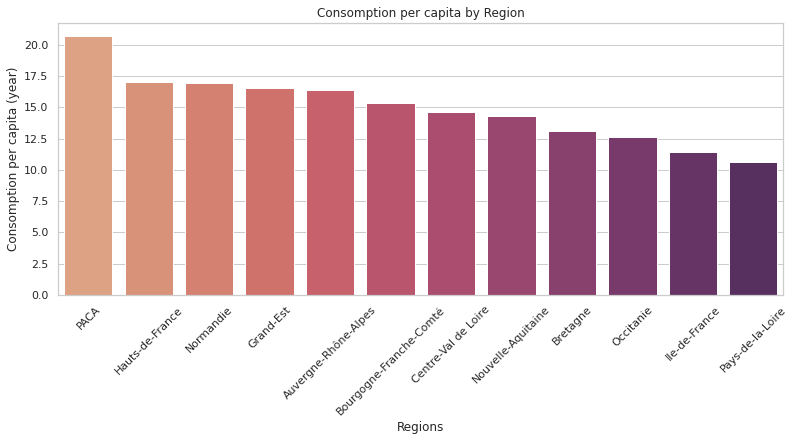

In [26]:
# Ploting Consumption per capita (Regions)

regions_consom_per_capita = regions_consom_per_capita.reset_index()

sns.set(style='whitegrid')

plt.figure(figsize=(13, 5)) 
sns.barplot(x='Regions', y='Consomption_per_capita(year)', 
            data=regions_consom_per_capita, 
            palette='flare', 
            hue='Regions', legend=False)

plt.xlabel('Regions')
plt.ylabel('Consomption per capita (year)')
plt.title('Consomption per capita by Region')

plt.xticks(rotation=45)

plt.show()


#### 1.5. Quelles régions sont les plus consommatrices par km2 ? Que pouvez-vous dire des résultats ?
___________________________________________

##### 1.5.1 Cleaning and Organisation

In [27]:
# Defining New Variable (regions_size)
regions_size = regions_consom_per_capita
regions_size = regions_size.sort_values(by='Regions', ascending=True)

In [28]:
# Adding a new column
regions_size['Superficie(km2)'] = ['69711','47784','27208','39151','57441','31806','12011','29907','84036','72724','31400','32082'] 


In [29]:
# Dropping useless columns
regions_size = regions_size.drop(columns=['Population_2022','Consomption_per_capita(year)'])

In [30]:

regions_consom_per_size = regions_size

In [31]:
regions_consom_per_size=regions_consom_per_size.astype({'Superficie(km2)':'int'})
regions_consom_per_size.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 4 to 11
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Regions           12 non-null     object
 1   Consomption(Gwh)  12 non-null     int64 
 2   Superficie(km2)   12 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 384.0+ bytes


In [32]:
# Dividing Consomption per Superficie
regions_consom_per_size['Consomption_per_size(Gwh/km2)']=regions_consom_per_size['Consomption(Gwh)']/regions_consom_per_size['Superficie(km2)']
regions_consom_per_size.sort_values(by='Consomption_per_size(Gwh/km2)', ascending=False)

,Regions,Consomption(Gwh),Superficie(km2),Consomption_per_size(Gwh/km2)
10,Ile-de-France,141593960,12011,11788.690367
1,Hauts-de-France,101815048,31806,3201.127083
0,PACA,80884421,31400,2575.936975
4,Auvergne-Rhône-Alpes,134068058,69711,1923.198032
2,Normandie,56079329,29907,1875.123851
11,Pays-de-la-Loire,54793090,32082,1707.907549
8,Bretagne,45053105,27208,1655.877132
3,Grand-Est,91868917,57441,1599.361380
9,Occitanie,76903481,72724,1057.470450
7,Nouvelle-Aquitaine,87595610,84036,1042.358156


In [33]:
regions_consom_per_size = regions_consom_per_size.sort_values(by='Consomption_per_size(Gwh/km2)', ascending=False)
regions_consom_per_size

,Regions,Consomption(Gwh),Superficie(km2),Consomption_per_size(Gwh/km2)
10,Ile-de-France,141593960,12011,11788.690367
1,Hauts-de-France,101815048,31806,3201.127083
0,PACA,80884421,31400,2575.936975
4,Auvergne-Rhône-Alpes,134068058,69711,1923.198032
2,Normandie,56079329,29907,1875.123851
11,Pays-de-la-Loire,54793090,32082,1707.907549
8,Bretagne,45053105,27208,1655.877132
3,Grand-Est,91868917,57441,1599.361380
9,Occitanie,76903481,72724,1057.470450
7,Nouvelle-Aquitaine,87595610,84036,1042.358156


##### 1.5.2 Answer:

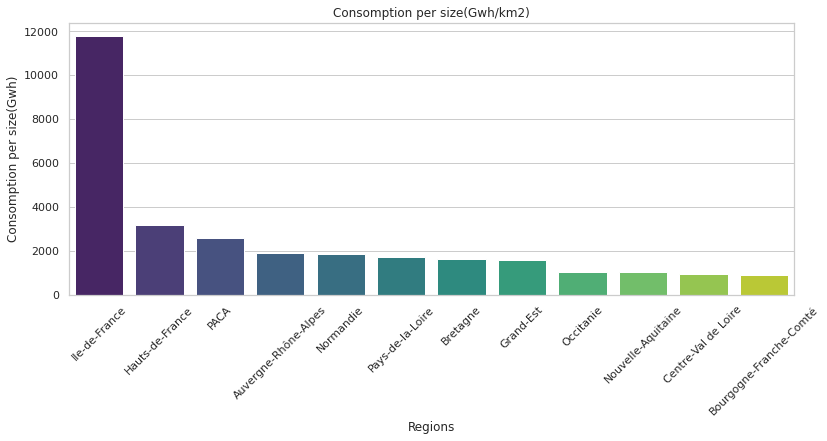

In [34]:
# Ploting Consomption per size(Gwh/km2)
sns.set(style='whitegrid')

plt.figure(figsize=(13, 5)) 
sns.barplot(x='Regions', y='Consomption_per_size(Gwh/km2)', 
            data=regions_consom_per_size, 
            palette='viridis',
            hue='Regions', legend=False)

plt.xlabel('Regions')
plt.ylabel('Consomption per size(Gwh)')
plt.title('Consomption per size(Gwh/km2)')

plt.xticks(rotation=45)

plt.show()

_______________________________________
### 2.Etude de la production non renouvelable
_______________________________________

#### 2.0 Cleaning and Organisation

In [35]:
regions_prod_non_renewable = df_regional

In [36]:
#WIP

# Selecting only columns of no renewable
regions_prod_non_renewable = (regions_prod_non_renewable.drop(columns=['Consommation', 'Eolien',
                                                            'Solaire', 'Hydraulique', 
                                                            'Pompage', 'Bioénergies','Ech. physiques'])
                                                     .dropna(how='all', axis='columns')
                                                     .dropna(how='all', axis='rows')
                                                     .replace('Nan', np.nan) 
                                                     .rename(columns={'Périmètre': 'Regions', 'Nucléaire':'Nucleaire'})
                                                            
                                                        )
                                                    
                                                                                                  
regions_prod_non_renewable

,Regions,Thermique,Nucleaire
2016-01-01 00:00:00,Ile-de-France,293.0,NaN
2016-01-01 00:30:00,Ile-de-France,309.0,NaN
2016-01-01 01:00:00,Ile-de-France,309.0,NaN
2016-01-01 01:30:00,Ile-de-France,311.0,NaN
2016-01-01 02:00:00,Ile-de-France,309.0,NaN
...,...,...,...
2013-12-31 21:30:00,Ile-de-France,272.0,NaN
2013-12-31 22:00:00,Ile-de-France,271.0,NaN
2013-12-31 22:30:00,Ile-de-France,271.0,NaN
2013-12-31 23:00:00,Ile-de-France,272.0,NaN


#### 2.1 Dans quelles régions produit-t-on le plus d'électricité d'origine non renouvelable ? 

In [37]:
# Sum up Consomption Thermique and Nucléaire
regions_prod_non_renewable['Non_renewable_energy'] = (regions_prod_non_renewable['Thermique'].fillna(0) +
                                                      regions_prod_non_renewable['Nucleaire'].fillna(0))


regions_prod_non_renewable


,Regions,Thermique,Nucleaire,Non_renewable_energy
2016-01-01 00:00:00,Ile-de-France,293.0,NaN,293.0
2016-01-01 00:30:00,Ile-de-France,309.0,NaN,309.0
2016-01-01 01:00:00,Ile-de-France,309.0,NaN,309.0
2016-01-01 01:30:00,Ile-de-France,311.0,NaN,311.0
2016-01-01 02:00:00,Ile-de-France,309.0,NaN,309.0
...,...,...,...,...
2013-12-31 21:30:00,Ile-de-France,272.0,NaN,272.0
2013-12-31 22:00:00,Ile-de-France,271.0,NaN,271.0
2013-12-31 22:30:00,Ile-de-France,271.0,NaN,271.0
2013-12-31 23:00:00,Ile-de-France,272.0,NaN,272.0


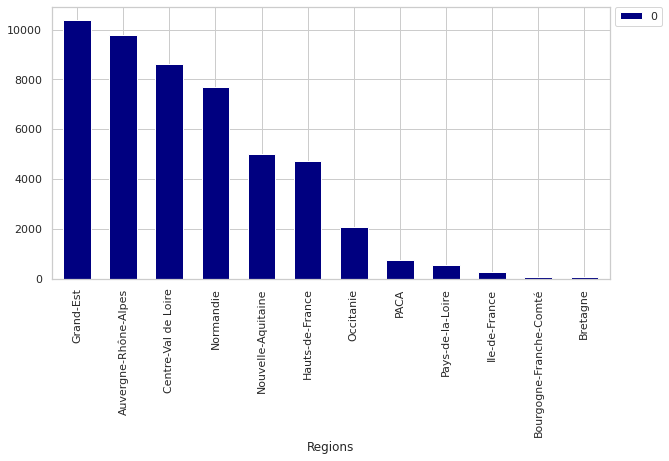

In [112]:
non_renewable=(regions_prod_non_renewable.drop(columns=['Thermique', 'Nucleaire'])
                              .groupby([pd.Grouper(freq="Y"), 'Regions'])
                              .mean()    
                              .unstack(level=0)
                              .mean(axis = 1)
                              #.droplevel(None, axis=0)
                              #.plot(kind='bar', figsize=(20, 6), width =0.7, colormap='seismic')

)


non_renewable = pd.DataFrame(non_renewable)
(non_renewable.sort_values(by=0, ascending=False)
              .plot(kind='bar', figsize=(10, 5), width =0.6, colormap='jet')

)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))
plt.xticks(rotation=90)
plt.show()

In [247]:
non_renewable

,0
Regions,
Auvergne-Rhône-Alpes,9769.762358
Bourgogne-Franche-Comté,81.952283
Bretagne,60.536110
Centre-Val de Loire,8600.840246
Grand-Est,10385.781074
Hauts-de-France,4718.049003
Ile-de-France,285.116585
Normandie,7704.176163
Nouvelle-Aquitaine,5001.198499


In [96]:
(
regions_prod_non_renewable.drop(columns=['Thermique', 'Nucleaire'])
                              .sort_values(by='Non_renewable_energy', ascending=False)
                              .groupby(['Regions', pd.Grouper(freq="Y")])
                              .mean()
                              .unstack(level=0)
).droplevel(None, axis = 1)

Regions,Auvergne-Rhône-Alpes,Bourgogne-Franche-Comté,Bretagne,Centre-Val de Loire,Grand-Est,Hauts-de-France,Ile-de-France,Normandie,Nouvelle-Aquitaine,Occitanie,PACA,Pays-de-la-Loire
2013-12-31,10295.706205,122.120269,29.407272,7832.751299,10312.523432,4683.392317,458.559678,8868.063702,4882.396427,2211.995376,609.950283,727.275358
2014-12-31,10150.529224,55.772831,37.734589,8914.279680,10491.050285,4413.408733,237.691495,8560.052112,4917.868779,1728.540639,364.493265,410.150856
2015-12-31,10602.555080,68.567237,47.190126,9077.368379,10589.669178,4908.882477,273.079281,7783.808447,4688.588299,2165.445662,698.644977,444.585103
2016-12-31,8828.721881,74.877618,65.697689,8650.376082,10569.605077,4511.899476,263.398395,7097.455146,4906.587375,2284.576047,1024.465392,458.472678
2017-12-31,9406.263527,81.867009,86.934703,8582.363584,10163.873973,4844.129566,278.554395,6623.397717,5283.505251,2057.819349,1094.626027,770.623059
2018-12-31,9334.798231,88.508733,96.252283,8547.902454,10187.964498,4946.581450,199.416267,7292.279852,5328.244863,1990.275228,666.892066,519.131336


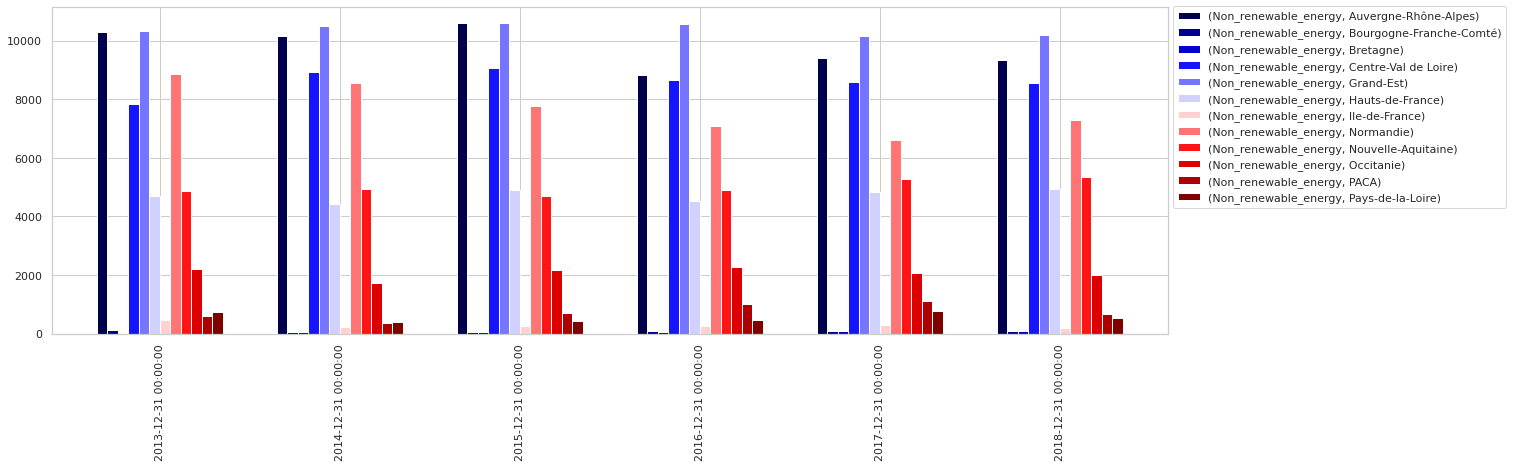

In [260]:

regions_prod_non_renewableplt = (regions_prod_non_renewable.drop(columns=['Thermique', 'Nucleaire'])
                              .sort_values(by='Non_renewable_energy', ascending=False)
                              .groupby(['Regions', pd.Grouper(freq="Y")])
                              .mean()
                              .unstack(level=0)
                              #.droplevel(None, axis = 1)
                              #.style.use('ggplot')

)



<AxesSubplot:>

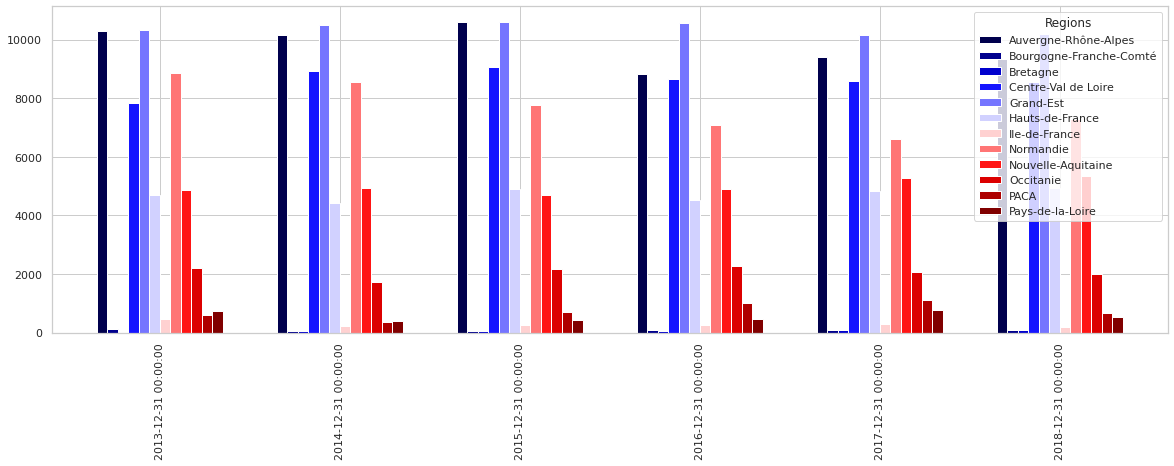

In [271]:

#Delete column appearing at the legend
regions_prod_non_renewableplt['Non_renewable_energy'].plot(kind='bar', figsize=(20, 6), width =0.7, colormap='seismic')

In [ ]:

regions_prod_non_renewableplt.plot(kind='bar', figsize=(20, 6), width =0.7, colormap='seismic')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))
plt.show()

#### 2.2 Quelle est l'évolution de la production d'électricité d'origine non renouvelable ? 

In [ ]:
nonrenewable_evol = regions_prod_non_renewable
nonrenewable_evol


,Regions,Thermique,Nucleaire,Non_renewable_energy
2016-01-01 00:00:00,Ile-de-France,293.0,NaN,293.0
2016-01-01 00:30:00,Ile-de-France,309.0,NaN,309.0
2016-01-01 01:00:00,Ile-de-France,309.0,NaN,309.0
2016-01-01 01:30:00,Ile-de-France,311.0,NaN,311.0
2016-01-01 02:00:00,Ile-de-France,309.0,NaN,309.0
...,...,...,...,...
2013-12-31 21:30:00,Ile-de-France,272.0,NaN,272.0
2013-12-31 22:00:00,Ile-de-France,271.0,NaN,271.0
2013-12-31 22:30:00,Ile-de-France,271.0,NaN,271.0
2013-12-31 23:00:00,Ile-de-France,272.0,NaN,272.0


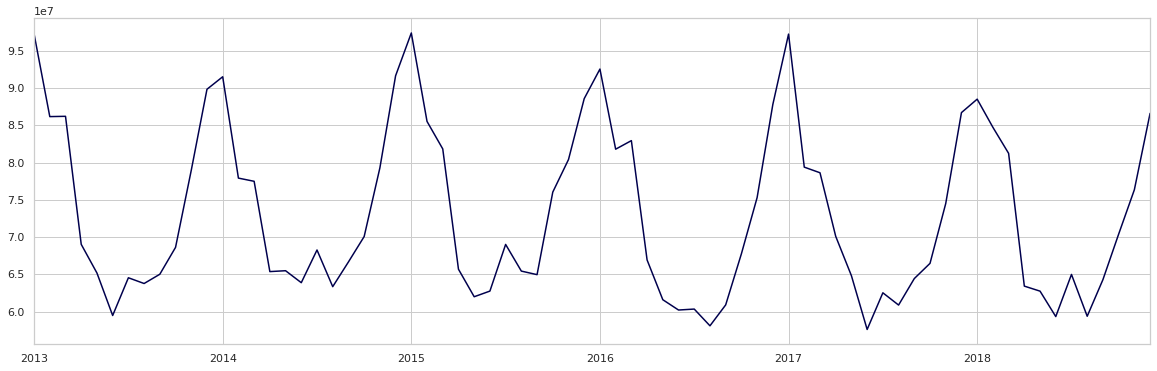

In [ ]:
nonrenewable_evol = (regions_prod_non_renewable.drop(columns=['Thermique', 'Nucleaire'])
                              .groupby(['Regions', pd.Grouper(freq="M")])
                              .sum()                             
                              .unstack(level=0)
                              .sum(axis = 1)
                              #.rolling('30D')
                              #.mean()
                              .plot(figsize=(20, 6), colormap='seismic')

)


<AxesSubplot:>

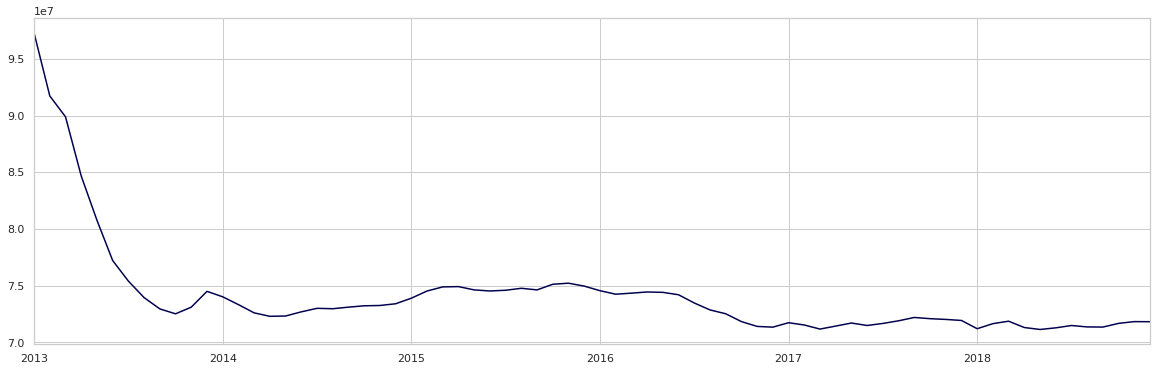

In [113]:
nonrenewable_evol = (regions_prod_non_renewable.loc[ : ,['Regions','Non_renewable_energy']]
                              .groupby(['Regions', pd.Grouper(freq="M")])
                              .sum()                             
                              .unstack(level=0)
                              .sum(axis = 1)
                              .rolling('365D')
                              .mean()
                              .plot(figsize=(20, 6), colormap='seismic')

)

nonrenewable_evol


<AxesSubplot:>

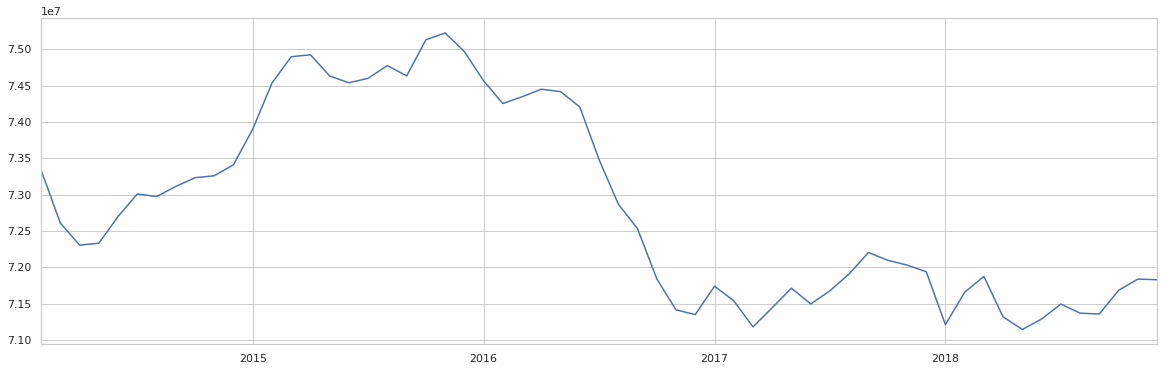

In [115]:
nonrenewable_evol = (regions_prod_non_renewable.loc[ : ,['Regions','Non_renewable_energy']]
                              .groupby(['Regions', pd.Grouper(freq="M")])
                              .sum()                             
                              .unstack(level=0)
                              .sum(axis = 1)
                              .rolling('365D')
                              .mean()
                              #.plot(figsize=(20, 6), colormap='seismic')

)

nonrenewable_evol.loc[nonrenewable_evol.index > '2014-01-31 23:59:59'].plot(figsize=(20,6))

<AxesSubplot:>

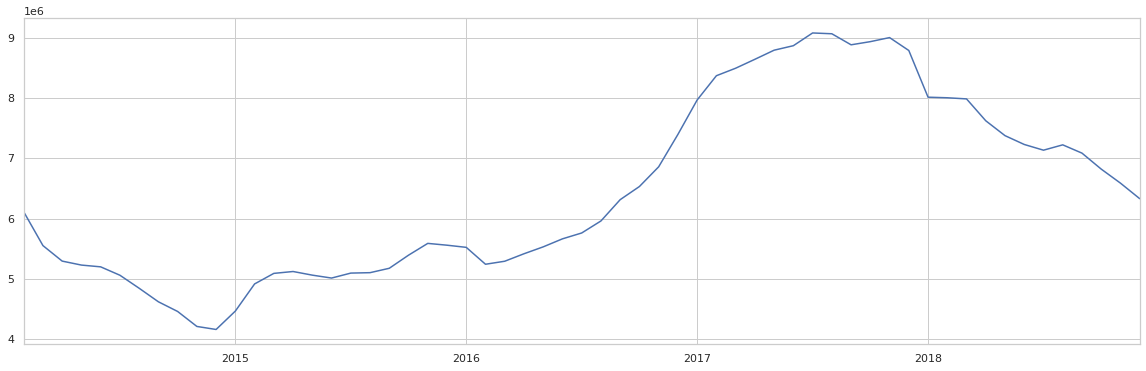

In [ ]:
nonrenewable_evol = (regions_prod_non_renewable.loc[ : ,['Regions','Thermique']]
                              .groupby(['Regions', pd.Grouper(freq="M")])
                              .sum()                             
                              .unstack(level=0)
                              .sum(axis = 1)
                              .rolling('365D')
                              .mean()
                              #.plot(figsize=(20, 6), colormap='seismic')

)

nonrenewable_evol.loc[nonrenewable_evol.index > '2014-01-31 23:59:59'].plot(figsize=(20,6))
                 

<AxesSubplot:>

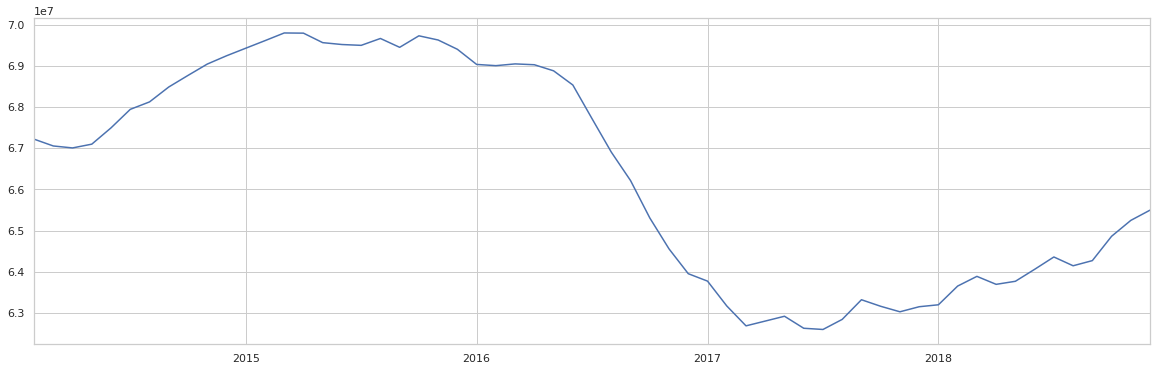

In [ ]:
nonrenewable_evol = (regions_prod_non_renewable.loc[ : ,['Regions','Nucleaire']]
                              .groupby(['Regions', pd.Grouper(freq="M")])
                              .sum()                             
                              .unstack(level=0)
                              .sum(axis = 1)
                              .rolling('365D')
                              .mean()
                              #.plot(figsize=(20, 6), colormap='seismic')

)

nonrenewable_evol.loc[nonrenewable_evol.index > '2014-01-31 23:59:59'].plot(figsize=(20,6))

#### 2.3 Afficher la production nucléaire totale par région sur l'ensemble de la période.    

In [ ]:
prod_nucleaire_regions = (regions_prod_non_renewable.loc[ : ,['Regions','Nucleaire']]
                                                             .groupby(['Regions', pd.Grouper(freq="Y")])
                                                             .sum()                             
                                                             .unstack(level=1)
                                                             .sum(axis = 1)
                                                             .sort_values(ascending=False)
                                                           

)

prod_nucleaire_regions = pd.DataFrame(prod_nucleaire_regions)
prod_nucleaire_regions

,0
Regions,
Auvergne-Rhône-Alpes,1.005175e+09
Grand-Est,9.782788e+08
Centre-Val de Loire,9.006820e+08
Normandie,7.586264e+08
Nouvelle-Aquitaine,5.156753e+08
Hauts-de-France,4.087612e+08
Occitanie,2.146697e+08
Bourgogne-Franche-Comté,0.000000e+00
Bretagne,0.000000e+00


#### 2.4 Dans quelles régions sont situées les centrales nucléaires ? Dans quelles régions n'y a-t-il pas de centrale nucléaire ?

<AxesSubplot:xlabel='Regions'>

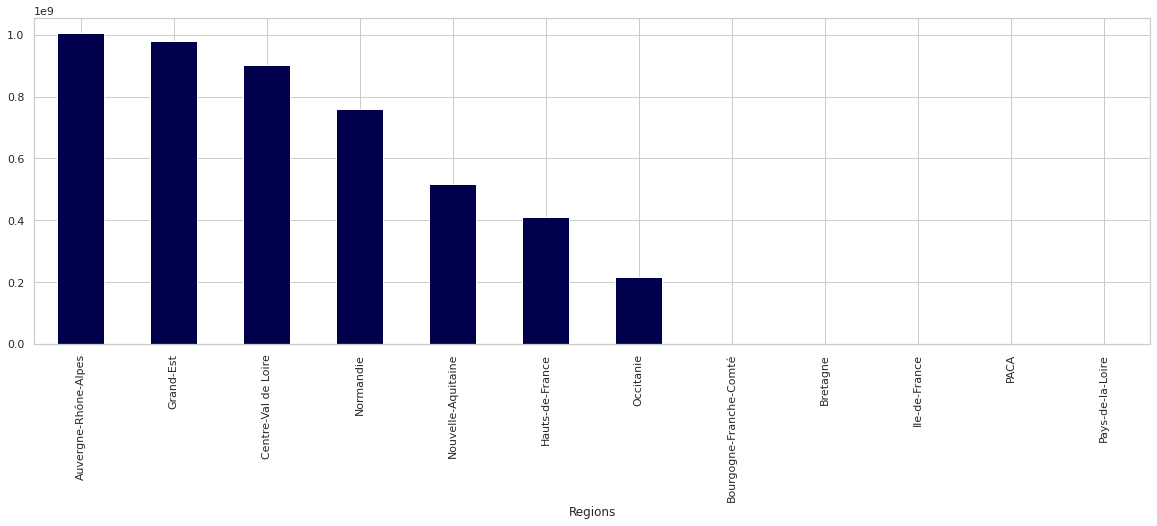

In [ ]:
prod_nucleaire_regions = (regions_prod_non_renewable.loc[ : ,['Regions','Nucleaire']]
                              .groupby(['Regions', pd.Grouper(freq="Y")])
                              .sum()                             
                              .unstack(level=1)
                              .sum(axis = 1)
                              .sort_values(ascending=False)
                              .plot(kind='bar', figsize=(20, 6), colormap='seismic')

)

prod_nucleaire_regions

_____________________________________________
### 3.Etude de la production renouvelable
_____________________________________________

#### 3.1 Quelle région produit le plus d'électricité d'origine renouvelable ?
   

In [ ]:
regions_prod_renewable = df_regional

#### 3.2 Quelle évolution sur les dernières années ? Faîtes un joli graphique. 
   
    

<AxesSubplot:xlabel='index'>

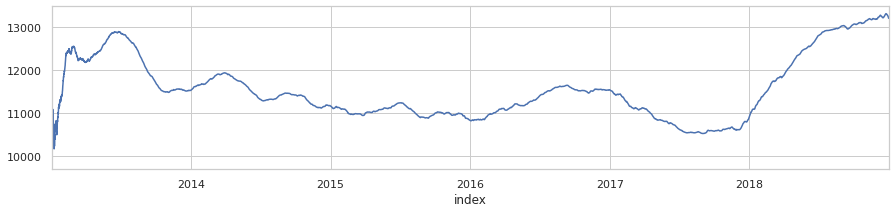

In [124]:

renewables = ['Eolien', 'Solaire', 'Hydraulique', 'Bioénergies']


renewable_regional_evoluc = (df_regional
                                .reset_index()
                                .groupby('index').sum()
                                .drop(columns='Périmètre')
                                .loc[:, renewables]
                                .sum(axis='columns')
                                .rolling('365D')
                                .mean())
                                

renewable_regional_evoluc.plot(figsize=(15, 3))

<AxesSubplot:xlabel='index'>

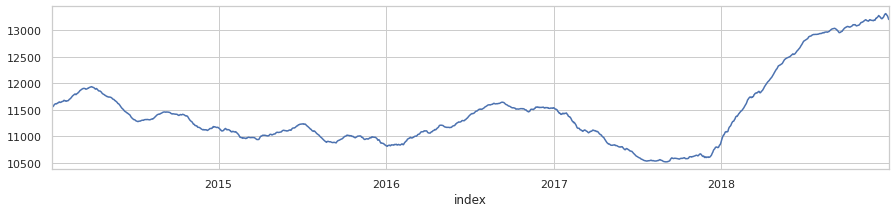

In [ ]:
renewable_regional_evoluc.loc[renewable_regional_evoluc.index > '2014-01-01 23:59:59'].plot(figsize=(15,3))

#### 3.3 Quelle région a le meilleur taux " énergie produite VS puissance installée " ? 
(Assimiler la puissance installée comme étant égale au maximum produit. Attention à bien définir vos critères, cette capacité peut augmenter dans le temps)

In [205]:
region_renewable = df_regional
region_renewable = (df_regional.loc[:, ['Périmètre'] + renewables])

In [259]:
(
region_renewable.groupby(['Périmètre', pd.Grouper(freq="M")])
                .sum().reset_index(names=['Périmètre', 'Date'])
)

,Périmètre,Date,Eolien,Solaire,Hydraulique,Bioénergies
0,Auvergne-Rhône-Alpes,2013-01-31,130835.0,27494.0,6070182.0,103065.0
1,Auvergne-Rhône-Alpes,2013-02-28,131009.0,41655.0,5598065.0,82818.0
2,Auvergne-Rhône-Alpes,2013-03-31,124316.0,68253.0,5148910.0,101623.0
3,Auvergne-Rhône-Alpes,2013-04-30,110378.0,78654.0,5880660.0,76124.0
4,Auvergne-Rhône-Alpes,2013-05-31,112269.0,101820.0,7467792.0,92089.0
...,...,...,...,...,...,...
859,Pays-de-la-Loire,2018-08-31,123526.0,136374.0,88.0,57177.0
860,Pays-de-la-Loire,2018-09-30,199092.0,117699.0,0.0,59761.0
861,Pays-de-la-Loire,2018-10-31,278894.0,86840.0,0.0,65129.0
862,Pays-de-la-Loire,2018-11-30,347405.0,52941.0,677.0,66263.0


In [255]:
#Regions_Max_renewable
region_max_renewable = (region_renewable.groupby(['Périmètre', pd.Grouper(freq="M")])
                                        .sum()
                                        .unstack(level=0)
                            )

region_max_renewable = region_max_renewable[renewables].max()
region_max_renewable = (pd.DataFrame(region_max_renewable)
                                    .unstack(level=0)
                                    )

region_max_renewable[0]


,Eolien,Solaire,Hydraulique,Bioénergies
Périmètre,,,,
Auvergne-Rhône-Alpes,279545.0,294293.0,7467792.0,211450.0
Bourgogne-Franche-Comté,399531.0,83737.0,352299.0,62852.0
Bretagne,540600.0,61974.0,125163.0,71556.0
Centre-Val de Loire,614259.0,82627.0,83309.0,97764.0
Grand-Est,1990349.0,238696.0,2008184.0,182083.0
Hauts-de-France,1986942.0,40486.0,3786.0,196185.0
Ile-de-France,37456.0,24805.0,15838.0,260324.0
Normandie,454438.0,42025.0,33944.0,101951.0
Nouvelle-Aquitaine,453041.0,808474.0,1529727.0,294664.0


In [230]:
region_renewable

,Périmètre,Eolien,Solaire,Hydraulique,Bioénergies
2016-01-01 00:00:00,Ile-de-France,18.0,0.0,10.0,137.0
2016-01-01 00:30:00,Ile-de-France,16.0,0.0,10.0,148.0
2016-01-01 01:00:00,Ile-de-France,13.0,0.0,10.0,149.0
2016-01-01 01:30:00,Ile-de-France,10.0,0.0,9.0,149.0
2016-01-01 02:00:00,Ile-de-France,7.0,0.0,10.0,149.0
...,...,...,...,...,...
2013-12-31 21:30:00,Ile-de-France,9.0,0.0,1.0,130.0
2013-12-31 22:00:00,Ile-de-France,8.0,0.0,1.0,134.0
2013-12-31 22:30:00,Ile-de-France,11.0,0.0,1.0,133.0
2013-12-31 23:00:00,Ile-de-France,10.0,0.0,1.0,137.0


In [243]:
df_regional.columns

Index(['Périmètre', 'Consommation', 'Thermique', 'Nucléaire', 'Eolien',
       'Solaire', 'Hydraulique', 'Pompage', 'Bioénergies', 'Ech. physiques'],
      dtype='object')

In [246]:
pd.pivot_table(
    data = df_regional,
    values = 'Consommation',
    index= 'Périmètre',
    columns =  ['Thermique', 'Nucléaire', 'Eolien', 'Solaire', 'Hydraulique']
)

Thermique            -18.0                           -17.0                    \
Nucléaire             2226.0  2250.0  2359.0  2396.0  2302.0  2427.0  2481.0   
Eolien                 146.0   149.0   171.0   157.0   150.0   146.0   244.0   
Solaire                0.0     0.0     0.0     0.0     0.0     0.0     317.0   
Hydraulique           1127.0  1125.0  1134.0  1140.0  1112.0  1119.0  1632.0   
Périmètre                                                                      
Auvergne-Rhône-Alpes     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Centre-Val de Loire      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Grand-Est                NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Hauts-de-France          NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Normandie                NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Nouvelle-Aquitaine       NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Occitanie             2561.0  2577.0  2653.0  2663.0  2637.0  2677.0  3701.0   

Thermique                            -16.0    ...  4185.0  4193.0  4194.0  \
Nucléaire             2487.0  2493.0  2357.0  ...  8336.0  9106.0  8339.0   
Eolien                 237.0   209.0   147.0  ...   510.0   382.0   503.0   
Solaire                262.0   201.0   0.0    ...   27.0    0.0     62.0    
Hydraulique           1628.0  1692.0  1125.0  ...  1336.0  1276.0  1320.0   
Périmètre                                     ...                           
Auvergne-Rhône-Alpes     NaN     NaN     NaN  ...     NaN     NaN     NaN   
Centre-Val de Loire      NaN     NaN     NaN  ...     NaN     NaN     NaN   
Grand-Est                NaN     NaN     NaN  ...  7476.0  7631.0  7457.0   
Hauts-de-France          NaN     NaN     NaN  ...     NaN     NaN     NaN   
Normandie                NaN     NaN     NaN  ...     NaN     NaN     NaN   
Nouvelle-Aquitaine       NaN     NaN     NaN  ...     NaN     NaN     NaN   
Occitanie             3665.0  3571.0  2764.0  ...     NaN     NaN     NaN   

Thermique             4200.0  4207.0  4218.0  4224.0  4259.0  4285.0  4293.0  
Nucléaire             8336.0  8269.0  8211.0  8335.0  8433.0  8330.0  8336.0  
Eolien                 541.0   14.0    11.0    575.0   7.0     9.0     7.0    
Solaire                44.0    0.0     0.0     82.0    0.0     0.0     0.0    
Hydraulique           1243.0  815.0   817.0   1240.0  902.0   1313.0  1318.0  
Périmètre                                                                     
Auvergne-Rhône-Alpes     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
Centre-Val de Loire      NaN     NaN     NaN     NaN     NaN     NaN     NaN  
Grand-Est             7520.0  7211.0  7474.0  7655.0  7500.0  7769.0  7621.0  
Hauts-de-France          NaN     NaN     NaN     NaN     NaN     NaN     NaN  
Normandie                NaN     NaN     NaN     NaN     NaN     NaN     NaN  
Nouvelle-Aquitaine       NaN     NaN     NaN     NaN     NaN     NaN     NaN  
Occitanie                NaN     NaN     NaN     NaN     NaN     NaN     NaN  

[7 rows x 735904 columns]

In [228]:
#Regions_Renewable_yearly_mean

regions_renewable_prod_year = (region_renewable.groupby(['Périmètre', pd.Grouper(freq="")])
                                               .mean()
                                               .unstack(level=0)
                                               .rolling('365D')
                                               .mean()
                              )

#regions_renewable_prod_year.plot(figsize=(20, 6), colormap='seismic')


regions_renewable_prod_year

Eolien                                      \
Périmètre  Auvergne-Rhône-Alpes Bourgogne-Franche-Comté    Bretagne   
2013-12-31            83.971402               32.035790  159.983504   
2014-12-31            87.260845               42.739840  159.516952   
2015-12-31            91.272032               79.391895  188.572546   
2016-12-31            97.655681               88.747439  168.445071   
2017-12-31           115.092637              125.727169  176.438185   
2018-12-31           123.462557              149.648345  205.919463   

                                                                          \
Périmètre  Centre-Val de Loire   Grand-Est Hauts-de-France Ile-de-France   
2013-12-31          172.677179  419.533478      371.321080      3.952951   
2014-12-31          185.680365  454.055651      415.906906      4.319806   
2015-12-31          220.133333  589.803368      567.103995      6.003938   
2016-12-31          205.167520  562.302766      562.781421      6.929246   
2017-12-31          215.649144  635.542295      659.061358     10.459361   
2018-12-31          233.221347  723.623174      821.146804     13.848059   

                                                       ... Bioénergies  \
Périmètre    Normandie Nouvelle-Aquitaine   Occitanie  ...    Bretagne   
2013-12-31  109.552086          80.551630  249.864205  ...   21.875678   
2014-12-31  119.479167          93.680879  250.108447  ...   31.857763   
2015-12-31  143.833162         105.529966  264.642808  ...   35.550913   
2016-12-31  134.824852         105.226150  293.201901  ...   35.450763   
2017-12-31  147.822603         140.547374  357.066495  ...   41.167409   
2018-12-31  173.283219         198.230822  371.238128  ...   43.096233   

                                                                         \
Périmètre  Centre-Val de Loire  Grand-Est Hauts-de-France Ile-de-France   
2013-12-31           28.370797  51.070267       68.560706    122.203436   
2014-12-31           46.963699  66.765582       89.517180    141.431564   
2015-12-31           48.262500  72.935331      108.291495    118.301199   
2016-12-31           49.213570  90.778689      108.064492    141.078837   
2017-12-31           57.099087  95.014441      114.626027    147.690696   
2018-12-31           59.453539  96.625799      119.100514    145.332934   

                                                                 \
Périmètre   Normandie Nouvelle-Aquitaine  Occitanie        PACA   
2013-12-31  45.113363         129.176608  70.536275   51.341515   
2014-12-31  55.749144         135.784247  77.571119   61.664441   
2015-12-31  52.197546         158.479623  80.589726   73.088071   
2016-12-31  47.649989         159.747666  86.807206  104.244308   
2017-12-31  49.158162         183.308048  86.554795  129.834646   
2018-12-31  50.014897         175.450856  82.432021  121.757991   

                             
Périmètre  Pays-de-la-Loire  
2013-12-31        33.149951  
2014-12-31        40.557192  
2015-12-31        39.248973  
2016-12-31        38.100694  
2017-12-31        43.760331  
2018-12-31        43.931164  

[6 rows x 48 columns]

__________________________________________________
### 4.Autonomie électrique des régions
___________________________________________________

#### 4.1. Afficher la différence entre la consommation et la production pour chaque région.

#### 4.2. Quelles régions sont autonomes ? En excès ? En déficit ?

#### 4.3. Comparer ce résultat à la colonne 'Ech. physiques'

#### 4.4. Afficher un histogramme de l'écart entre énergie produite et consommée. Calculer la moyenne et la variance de cet écart.

#### 4.5. Observer les informations concernant la région AuRA. Retrouver la signification du signe des échanges. Pourquoi la région est-elle autant exportatrice ?

====================================== Work Done ======================================